In [1]:
from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
import matplotlib.pyplot as plt
from time import time

G:\anaconda\lib\site-packages\requests\packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


## Get Data

In [2]:
mnist_train = datasets.FashionMNIST(train=True)
X, y = mnist_train[0]
('X shape: ', X.shape, 'X dtype', X.dtype, 'y:', y)

('X shape: ', (28, 28, 1), 'X dtype', numpy.uint8, 'y:', 2)

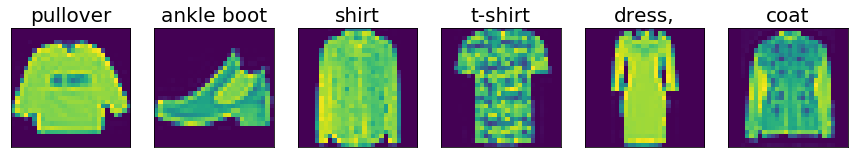

In [3]:
text_labels = [
    't-shirt', 'trouser', 'pullover', 'dress,', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
]
X, y = mnist_train[0:6]
# plot images
_, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
for f,x,yi in zip(figs, X,y):
    # 3D->2D by removing the last channel dim
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

mnist_train = mnist_train.transform_first(transformer)

G:\anaconda\lib\site-packages\mxnet\gluon\nn\basic_layers.py:83: UserWarning: All children of this Sequential layer are HybridBlocks. Consider using HybridSequential for the best performance.
  warnings.warn('All children of this Sequential layer are HybridBlocks. Consider ' \


# !!!num_workers在windows上不能大于0

In [5]:
batch_size = 256

# train_data = gluon.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
train_data = gluon.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

In [6]:
for data, label in train_data:
    print(data.shape, label.shape)
    break

(256, 1, 28, 28) (256,)


In [7]:
mnist_valid = gluon.data.vision.FashionMNIST(train=False)
valid_data = gluon.data.DataLoader(
    mnist_valid.transform_first(transformer),
    batch_size=batch_size)

## Define the model

In [8]:
net = nn.Sequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10)
    )
net.initialize(init=init.Xavier())

In [9]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [10]:
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) ==
            label.astype('float32')).mean().asscalar()

## Train

In [11]:
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': 0.1})

In [12]:
for epoch in range(10):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time()
    for data, label in train_data:
        # forward + backward
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        # update parameters
        trainer.step(batch_size)
        # calculate traing metrics
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label)

    # calculate validation accuracy
    for data, label in valid_data:
        valid_acc += acc(net(data), label)

    print("Epoch %d: Loss: %.3f, Train acc %.3f, Test acc %.3f, \
Time %.1f sec" % (
        epoch, train_loss/len(train_data),
        train_acc/len(train_data),
        valid_acc/len(valid_data), time()-tic))

Epoch 0: Loss: 0.840, Train acc 0.695, Test acc 0.805, Time 18.7 sec
Epoch 1: Loss: 0.467, Train acc 0.828, Test acc 0.847, Time 19.1 sec
Epoch 2: Loss: 0.399, Train acc 0.854, Test acc 0.863, Time 19.2 sec
Epoch 3: Loss: 0.365, Train acc 0.866, Test acc 0.871, Time 18.8 sec
Epoch 4: Loss: 0.338, Train acc 0.876, Test acc 0.872, Time 18.8 sec
Epoch 5: Loss: 0.319, Train acc 0.883, Test acc 0.887, Time 18.9 sec
Epoch 6: Loss: 0.305, Train acc 0.887, Test acc 0.890, Time 18.7 sec
Epoch 7: Loss: 0.292, Train acc 0.893, Test acc 0.883, Time 19.0 sec
Epoch 8: Loss: 0.283, Train acc 0.895, Test acc 0.892, Time 18.9 sec
Epoch 9: Loss: 0.271, Train acc 0.900, Test acc 0.898, Time 18.8 sec
